In [1]:
%matplotlib widget

import multiprocessing
import os
from os import path

import numpy as np
from matplotlib import pyplot as plt

import analysis

In [2]:
def load_batch(exp_dirs):
    print(f"Loading {len(exp_dirs)} experiments.")
    with multiprocessing.Pool() as pool:
        exp_to_data = dict(
            zip(exp_dirs, pool.map(analysis.get_all_metrics_for_exp, exp_dirs))
        )
    print(f"Loaded {len(exp_to_data)} experiments.")
    return exp_to_data


def load_sweep(sweep_dir):
    exp_dirs = [
        path.join(sweep_dir, dirn) for dirn in os.listdir(sweep_dir) if dirn != "graphs"
    ]
    print(f"Found {len(exp_dirs)} experiments.")
    return load_batch(exp_dirs)

In [3]:
delack_sweep_dir = "/data_hdd/incast/out/delack_sweep_2ms"
delack_sweep_exp_to_data = load_sweep(delack_sweep_dir)

Found 6 experiments.
Loading 6 experiments.


/home/ccanel/src/incast-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ccanel/src/incast-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ccanel/src/incast-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ccanel/src/incast-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/ccanel/src/incast-analysis/.venv/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, ax

Loaded 6 experiments.


In [4]:
def graph_delack_sweep(exp_to_data, sweep_dir):
    graph_dir = path.join(sweep_dir, "graphs")
    if not path.isdir(graph_dir):
        os.makedirs(graph_dir)

    def get_x(data):
        return data["config"]["delAckCount"]

    def get_y(data):
        return np.mean([end - start for start, end in data["burst_times"][1:]])

    points = [(get_x(data), get_y(data)) for exp, data in exp_to_data.items()]
    points = sorted(points)
    xs, ys = zip(*points)
    ys = [y * 1e3 for y in ys]

    fig, axes = analysis.get_axes(rows=1, width=5, cols=1)
    ax = axes[0]

    ax.plot(xs, ys, "o-", alpha=0.8)

    ax.set_title(f"Average burst duration vs. DelAckCount")
    ax.set_xlabel("DelAckCount")
    ax.set_ylabel("Burst duration (ms)")
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    plt.tight_layout()
    analysis.show(fig)
    analysis.save(graph_dir, suffix="duration")


def graph_delack_sweep_cdf(exp_to_data, sweep_dir):
    graph_dir = path.join(sweep_dir, "graphs")
    if not path.isdir(graph_dir):
        os.makedirs(graph_dir)

    label_to_durations = {
        data["config"]["delAckCount"]: [
            (end - start) * 1e3 for start, end in data["burst_times"]
        ]
        for exp, data in exp_to_data.items()
    }

    fig, axes = analysis.get_axes(rows=1, width=5, cols=1)
    ax = axes[0]

    for label, durations in sorted(label_to_durations.items()):
        plt.plot(
            np.sort(durations),
            np.arange(1, len(durations) + 1) / float(len(durations)),
            drawstyle="steps-post",
            label=label,
            alpha=0.8,
        )

    ideal_ms = list(set(data["ideal_sec"] * 1e3 for data in exp_to_data.values()))
    assert len(ideal_ms) == 1
    ideal_ms = ideal_ms[0]
    # plt.axvline(ideal_ms, color="b", linestyle="dashed", label="Ideal")

    ax.set_title(f"Burst duration CDF for various DelAckCount")
    ax.set_xlabel("Burst duration (ms)")
    ax.set_ylabel("CDF")
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0, top=1.01)
    # ax.legend()

    plt.tight_layout()
    analysis.show(fig)
    analysis.save(graph_dir, suffix="duration_cdf")

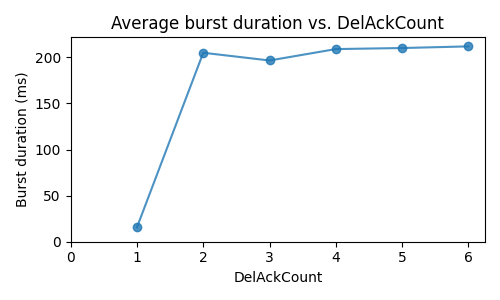

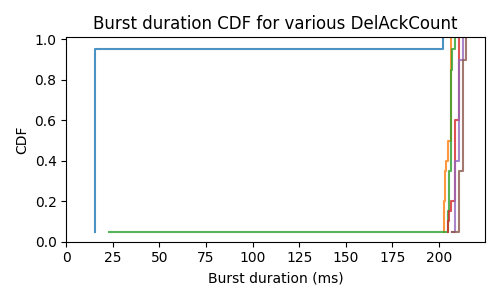

In [5]:
graph_delack_sweep(delack_sweep_exp_to_data, delack_sweep_dir)
graph_delack_sweep_cdf(delack_sweep_exp_to_data, delack_sweep_dir)

Interesting things to plot:
- RTT CDF: Randomly sample 1000 RTTs from each configuration, whenever there is actually traffic flowing
- Average non-empty queue depth: Average depth of the incast queue whenever it's not 0 or 1.

In [6]:
# Randomly sample 1000 points
# Plot CDF